# Biostat 626 - Midterm 2
## Ximiao Li

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from kneed import KneeLocator
from sklearn import manifold
from sklearn.manifold import TSNE
import warnings
warnings.filterwarnings("ignore")

# Data Preprocess

In [2]:
df = pd.read_csv('hgdp.txt', sep=' ', header=None)
df = df.iloc[:, :-1]

# Rename the columns
df = df.rename(columns={0:'Individual_ID', 1:'location', 2:'continent'})
for i in range(3, df.shape[1]):
    df = df.rename(columns={i:'geno_SNP'+str(i-2)})

df

,Individual_ID,location,continent,geno_SNP1,geno_SNP2,geno_SNP3,geno_SNP4,geno_SNP5,geno_SNP6,geno_SNP7,...,geno_SNP2531,geno_SNP2532,geno_SNP2533,geno_SNP2534,geno_SNP2535,geno_SNP2536,geno_SNP2537,geno_SNP2538,geno_SNP2539,geno_SNP2540
0,427,Pakistan,CENTRAL_SOUTH_ASIA,AA,CC,AA,GG,TT,CC,TC,...,GG,GG,GG,TT,AA,AA,CC,TT,GG,AA
1,745,Siberia,EAST_ASIA,AA,CC,AG,GA,TT,CC,CT,...,AG,GG,GG,TT,GA,GA,CC,TT,GG,TA
2,449,Pakistan,CENTRAL_SOUTH_ASIA,AA,CC,AA,GA,TT,CG,CC,...,GG,GG,GG,TT,AA,AA,CC,AT,AG,TA
3,876,France,EUROPE,AA,CT,AA,AG,TT,CG,TT,...,GG,GG,GG,TT,AA,AA,CC,TA,GA,TT
4,555,China,EAST_ASIA,AA,CC,AG,GA,CT,CC,TT,...,GG,GG,AG,GT,AA,AA,TC,TT,GG,TT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
922,460,Pakistan,CENTRAL_SOUTH_ASIA,AA,CC,GG,AG,TC,CC,CC,...,GG,GG,GG,GT,AG,AG,TC,TA,GA,TT
923,796,NewGuinea,OCEANIA,AA,CT,GA,AG,TT,CC,CC,...,GG,GG,GG,TT,GA,GA,CC,AT,AG,TA
924,403,Pakistan,CENTRAL_SOUTH_ASIA,AA,CC,AG,AA,TT,CC,CT,...,GA,GA,GG,TG,GA,GG,CC,AT,GG,TT
925,863,France,EUROPE,AA,CT,AA,AA,TT,CC,TT,...,GG,GG,GG,TT,AA,AA,CC,AT,AG,TA


In [3]:
# return reference list
def getref(df):
    geno_list = df.iloc[0,3:]
    ref_list = list()
    for geno in geno_list:
        ref_list.append(geno[0])
        
    return ref_list

# convert geno type to numeric values
def geno2num(df, ref):
    newdf = df.copy(deep=True)
    
    for j in range(len(ref)):
        numeric = list()
        col = newdf.columns[j+3]
        
        for geno in newdf[col]:
            if geno[0] == ref[j] and geno[1] == ref[j]:
                numeric.append(2)
            elif geno[0] == ref[j] or geno[1] == ref[j]:
                numeric.append(1)
            else:
                numeric.append(0)
            
        newdf[col] = pd.Series(numeric)
    
    return newdf

In [4]:
# Now convert the original dataframe to a new one
# Note that we use a deep copy so it wouldn't affect the original df
ref_list = getref(df)
newdf = geno2num(df, ref_list)
newdf

,Individual_ID,location,continent,geno_SNP1,geno_SNP2,geno_SNP3,geno_SNP4,geno_SNP5,geno_SNP6,geno_SNP7,...,geno_SNP2531,geno_SNP2532,geno_SNP2533,geno_SNP2534,geno_SNP2535,geno_SNP2536,geno_SNP2537,geno_SNP2538,geno_SNP2539,geno_SNP2540
0,427,Pakistan,CENTRAL_SOUTH_ASIA,2,2,2,2,2,2,1,...,2,2,2,2,2,2,2,2,2,2
1,745,Siberia,EAST_ASIA,2,2,1,1,2,2,1,...,1,2,2,2,1,1,2,2,2,1
2,449,Pakistan,CENTRAL_SOUTH_ASIA,2,2,2,1,2,1,0,...,2,2,2,2,2,2,2,1,1,1
3,876,France,EUROPE,2,1,2,1,2,1,2,...,2,2,2,2,2,2,2,1,1,0
4,555,China,EAST_ASIA,2,2,1,1,1,2,2,...,2,2,1,1,2,2,1,2,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
922,460,Pakistan,CENTRAL_SOUTH_ASIA,2,2,0,1,1,2,0,...,2,2,2,1,1,1,1,1,1,0
923,796,NewGuinea,OCEANIA,2,1,1,1,2,2,0,...,2,2,2,2,1,1,2,1,1,1
924,403,Pakistan,CENTRAL_SOUTH_ASIA,2,2,1,0,2,2,1,...,1,1,2,1,1,0,2,1,2,0
925,863,France,EUROPE,2,1,2,0,2,2,2,...,2,2,2,2,2,2,2,1,1,1


In [5]:
# Get features and Scalarize the data
geno = newdf.iloc[:,3:]
geno
# sc = StandardScaler()
# geno_scale = StandardScaler().fit_transform(geno)

,geno_SNP1,geno_SNP2,geno_SNP3,geno_SNP4,geno_SNP5,geno_SNP6,geno_SNP7,geno_SNP8,geno_SNP9,geno_SNP10,...,geno_SNP2531,geno_SNP2532,geno_SNP2533,geno_SNP2534,geno_SNP2535,geno_SNP2536,geno_SNP2537,geno_SNP2538,geno_SNP2539,geno_SNP2540
0,2,2,2,2,2,2,1,2,1,2,...,2,2,2,2,2,2,2,2,2,2
1,2,2,1,1,2,2,1,2,2,1,...,1,2,2,2,1,1,2,2,2,1
2,2,2,2,1,2,1,0,2,0,2,...,2,2,2,2,2,2,2,1,1,1
3,2,1,2,1,2,1,2,1,2,2,...,2,2,2,2,2,2,2,1,1,0
4,2,2,1,1,1,2,2,1,2,2,...,2,2,1,1,2,2,1,2,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
922,2,2,0,1,1,2,0,2,2,1,...,2,2,2,1,1,1,1,1,1,0
923,2,1,1,1,2,2,0,2,2,1,...,2,2,2,2,1,1,2,1,1,1
924,2,2,1,0,2,2,1,1,2,1,...,1,1,2,1,1,0,2,1,2,0
925,2,1,2,0,2,2,2,0,2,2,...,2,2,2,2,2,2,2,1,1,1


# Problem 1

## PCA

In [28]:
# PCA
pca = PCA(n_components = 153)
# principalComponents = pca.fit_transform(geno_scale)
principalComponents = pca.fit_transform(geno)
pcDF = pd.DataFrame(data = principalComponents)
pcDF

,0,1,2,3,4,5,6,7,8,9,...,143,144,145,146,147,148,149,150,151,152
0,6.515590,-2.447210,0.036600,4.615889,1.645751,-2.692038,4.361089,-2.565963,0.814571,4.897087,...,-0.164732,-2.148368,-0.827896,-0.458018,-2.372505,-1.569534,0.034562,-0.865846,-1.856678,0.268746
1,-5.859352,-4.734523,-6.977058,-2.806488,-8.684620,3.077656,-3.117856,4.482142,-2.951151,-6.444268,...,1.026091,-3.014177,2.459903,-2.265762,-0.360035,0.107803,-0.055733,1.319501,-1.138382,-0.478103
2,4.772323,-5.121649,0.249815,-2.178334,3.395142,2.820594,4.535674,0.504072,2.366040,4.626785,...,2.438866,-0.049186,0.710521,-1.448293,-2.607214,0.414713,-0.108994,-2.962365,2.723249,0.553553
3,9.695379,1.760626,-0.217383,-0.199699,-3.443935,3.110540,-10.080641,7.556254,7.562703,-3.234881,...,-0.122176,0.156454,-0.536355,-0.255707,1.087105,0.931090,1.947011,1.406850,0.963236,-0.917019
4,-9.461393,-8.383846,-8.962875,-1.262533,-0.935667,-4.935495,-3.105092,-2.098522,-3.982934,4.638660,...,0.777126,-1.116778,-0.318682,0.891257,-1.913352,0.086004,-0.391450,0.700823,2.179537,1.916789
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
922,3.427713,-0.492646,-2.454188,1.315447,0.748005,-5.150911,-5.464578,6.386622,6.525540,0.763138,...,1.485787,-0.502594,0.677022,-0.097599,1.013316,-0.590841,1.709792,-2.636207,-1.085535,2.383707
923,-4.787078,1.127079,-4.028358,16.592970,0.289728,14.598073,-3.688551,-1.602030,-0.828005,-0.250685,...,1.108286,1.026413,2.557139,-1.176608,2.710302,0.661180,1.406545,-1.708617,0.019983,0.680716
924,2.889517,0.996755,-7.446479,-0.518632,-4.674291,-4.341475,3.785620,7.432737,1.873879,-4.977230,...,-0.816019,0.011158,1.204139,-1.054882,-0.682376,0.319088,-1.111815,0.912078,0.865960,-0.536430
925,11.537175,-3.221362,-5.725741,0.840937,0.831611,-0.199677,-1.513731,4.338164,1.985594,1.962691,...,-0.722776,-3.077815,0.752979,-0.087522,0.133127,-0.381389,0.248162,0.501386,0.261097,0.113562


In [7]:
# Preserve 80% of data variance
np.cumsum(pca.explained_variance_ratio_)[-1]
# pca.explained_variance_ratio_

0.8005956332898446

## K-Means Clustering

In [27]:
kmeans_kwargs = {
    "init": "random",
    "n_init": 10,
    "max_iter": 300,
    "random_state": 42,
}

# A list holds the SSE values for each k
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(pcDF)
    sse.append(kmeans.inertia_)

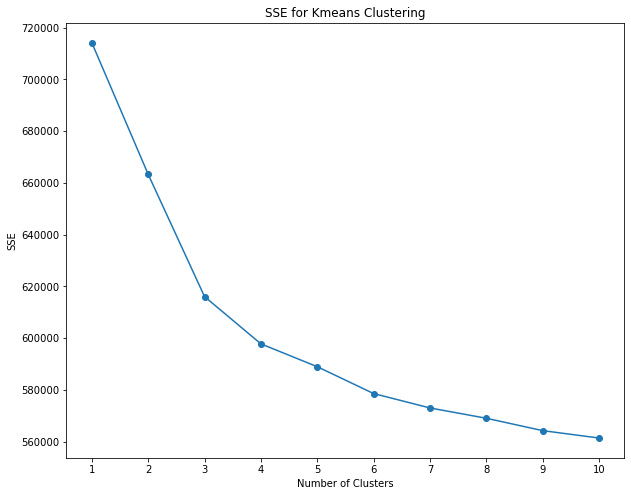

In [9]:
plt.figure(figsize=(10,8))
plt.plot(range(1, 11), sse, marker = 'o', linestyle = '-')
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.title('SSE for Kmeans Clustering')
plt.show()

In [10]:
# Explore elbow for SSE to get appropriate number of clusters
kl = KneeLocator(
    range(1, 11), sse, curve="convex", direction="decreasing"
)

n_clusters = kl.elbow
n_clusters

4

In [12]:
# Perform Kmeans with 4 clusters and get labels
pca_km = KMeans(n_clusters=n_clusters, **kmeans_kwargs)
km = pca_km.fit(pcDF)
labels = pd.Series(km.labels_)
data_plt = pd.concat([pcDF.iloc[:,:4], newdf['continent'], labels], axis = 1)

# Rename dataframe
col_names = ['PC1', 'PC2', 'PC3', 'PC4', 'continent', 'labels']
data_plt.columns = col_names
data_plt

,PC1,PC2,PC3,PC4,continent,labels
0,6.515590,-2.447210,0.036601,4.615887,CENTRAL_SOUTH_ASIA,1
1,-5.859352,-4.734523,-6.977057,-2.806491,EAST_ASIA,3
2,4.772323,-5.121650,0.249816,-2.178324,CENTRAL_SOUTH_ASIA,1
3,9.695379,1.760626,-0.217383,-0.199701,EUROPE,1
4,-9.461393,-8.383846,-8.962876,-1.262537,EAST_ASIA,3
...,...,...,...,...,...,...
922,3.427713,-0.492646,-2.454188,1.315444,CENTRAL_SOUTH_ASIA,1
923,-4.787078,1.127079,-4.028357,16.592965,OCEANIA,3
924,2.889517,0.996755,-7.446478,-0.518622,CENTRAL_SOUTH_ASIA,1
925,11.537175,-3.221362,-5.725740,0.840941,EUROPE,1


## Plot of PCs with Clustering results

In [13]:
# Get the Centroids
centroids = km.cluster_centers_

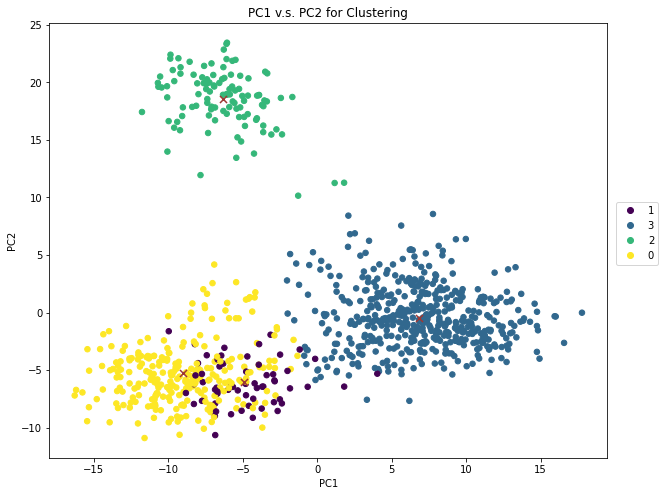

In [14]:
# Plot PC1 against PC2 from clustering
plt.figure(figsize=(10,8))
plot = plt.scatter(data_plt['PC1'], data_plt['PC2'], s = 30, c=data_plt['labels'])
plt.scatter(centroids[:,0] , centroids[:,1] , s = 50, color = '#9e3833', marker = 'x')
plt.legend(handles=plot.legend_elements()[0], labels=list(labels.unique()), loc='upper right', bbox_to_anchor=(1.1, 0.6))
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title('PC1 v.s. PC2 for Clustering')
plt.show()

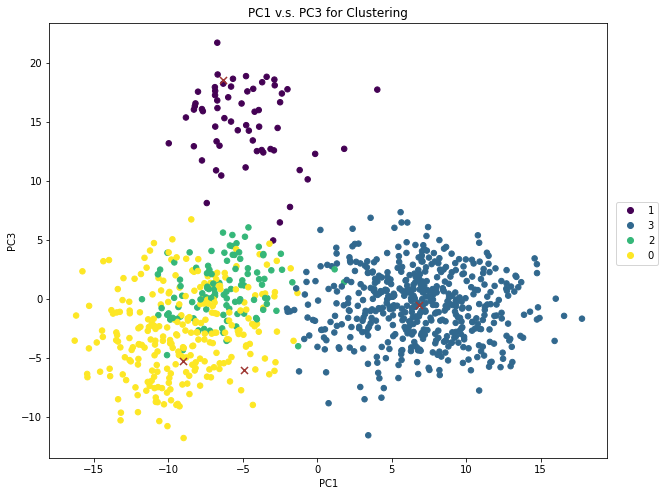

In [15]:
# Plot PC1 against PC3 from clustering
plt.figure(figsize=(10,8))
plot = plt.scatter(data_plt['PC1'], data_plt['PC3'], s = 30, c=data_plt['labels'])
plt.scatter(centroids[:,0] , centroids[:,1] , s = 50, color = '#9e3833', marker = 'x')
plt.legend(handles=plot.legend_elements()[0], labels=list(labels.unique()), loc='upper right', bbox_to_anchor=(1.1, 0.6))
plt.xlabel("PC1")
plt.ylabel("PC3")
plt.title('PC1 v.s. PC3 for Clustering')
plt.show()

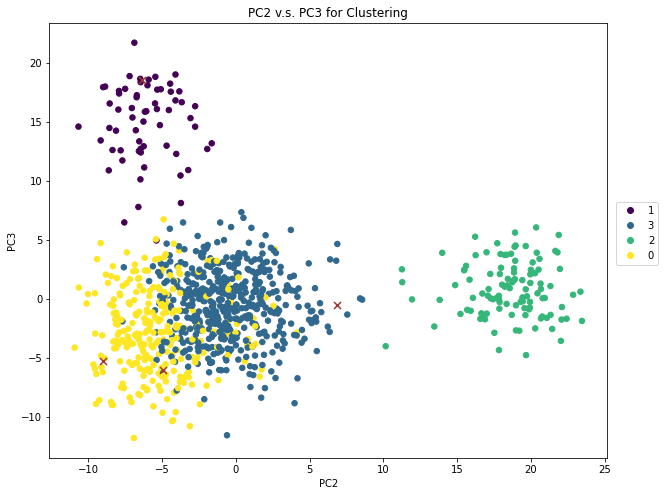

In [17]:
# Plot PC2 against PC3 from clustering
plt.figure(figsize=(10,8))
plot = plt.scatter(data_plt['PC2'], data_plt['PC3'], s = 30, c=data_plt['labels'])
plt.scatter(centroids[:,0] , centroids[:,1] , s = 50, color = '#9e3833', marker = 'x')
plt.legend(handles=plot.legend_elements()[0], labels=list(labels.unique()), loc='upper right', bbox_to_anchor=(1.1, 0.6))
plt.xlabel("PC2")
plt.ylabel("PC3")
plt.title('PC2 v.s. PC3 for Clustering')
plt.show()

## Comment

We need to take n=153 components in PCA to preserve more than 80% overall variance. 

After clustering, the data can be grouped into 4 parts, indicating our genotype data mainly has 4 distinct pattern. From the PC plot we can see the 4 clusters have been significantly split using only 3 PCs.

# Problem 2

In [19]:
# Specify colors to different continents
continent = data_plt['continent'].unique()
colors = {}
for i in range(len(continent)):
    colors[continent[i]] = i

## Plot of PCs with continental information

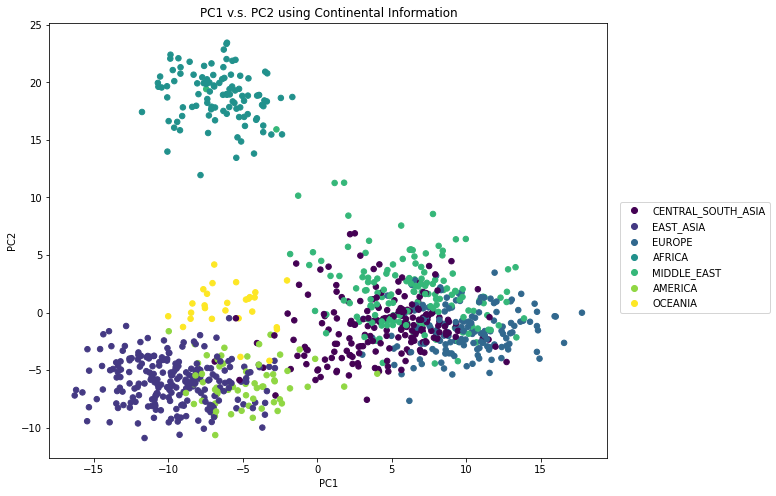

In [20]:
# Plot PC1 against PC2
plt.figure(figsize=(10,8))
plot = plt.scatter(data_plt['PC1'], data_plt['PC2'], s = 30, c=data_plt['continent'].map(colors))
plt.legend(handles=plot.legend_elements()[0], labels=list(continent), loc='upper right', bbox_to_anchor=(1.3, 0.6))
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title('PC1 v.s. PC2 using Continental Information')
plt.show()

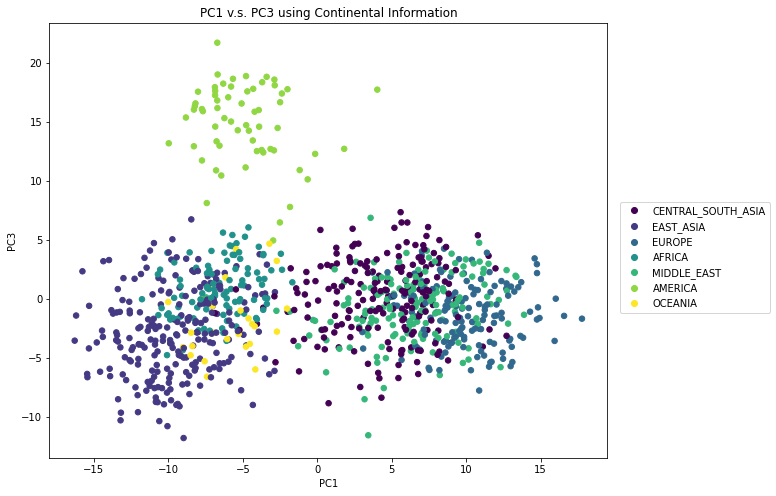

In [21]:
# Plot PC1 against PC3
plt.figure(figsize=(10,8))
plot = plt.scatter(data_plt['PC1'], data_plt['PC3'], s = 30, c=data_plt['continent'].map(colors))
plt.legend(handles=plot.legend_elements()[0], labels=list(continent), loc='upper right', bbox_to_anchor=(1.3, 0.6))
plt.xlabel("PC1")
plt.ylabel("PC3")
plt.title('PC1 v.s. PC3 using Continental Information')
plt.show()

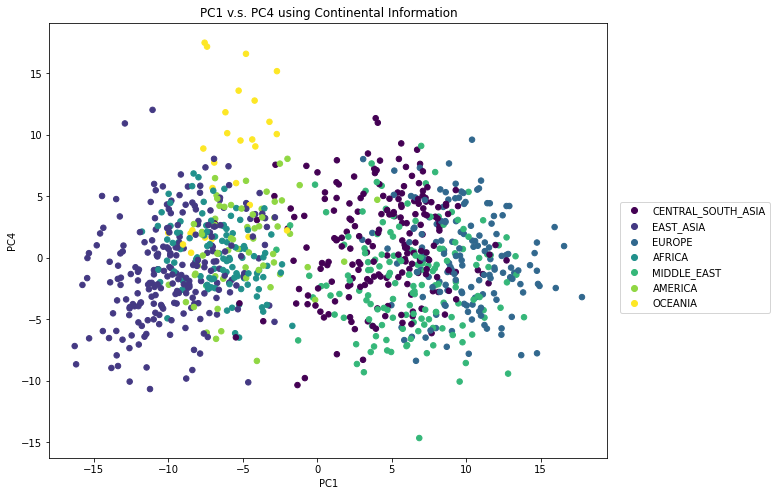

In [22]:
# Plot PC1 against PC4
plt.figure(figsize=(10,8))
plot = plt.scatter(data_plt['PC1'], data_plt['PC4'], s = 30, c=data_plt['continent'].map(colors))
plt.legend(handles=plot.legend_elements()[0], labels=list(continent), loc='upper right', bbox_to_anchor=(1.3, 0.6))
plt.xlabel("PC1")
plt.ylabel("PC4")
plt.title('PC1 v.s. PC4 using Continental Information')
plt.show()

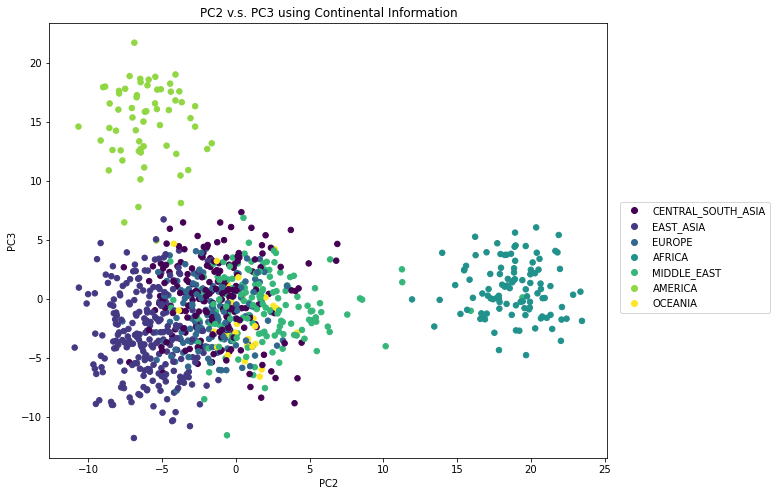

In [23]:
# Plot PC2 against PC3
plt.figure(figsize=(10,8))
plot = plt.scatter(data_plt['PC2'], data_plt['PC3'], s = 30, c=data_plt['continent'].map(colors))
plt.legend(handles=plot.legend_elements()[0], labels=list(continent), loc='upper right', bbox_to_anchor=(1.3, 0.6))
plt.xlabel("PC2")
plt.ylabel("PC3")
plt.title('PC2 v.s. PC3 using Continental Information')
plt.show()

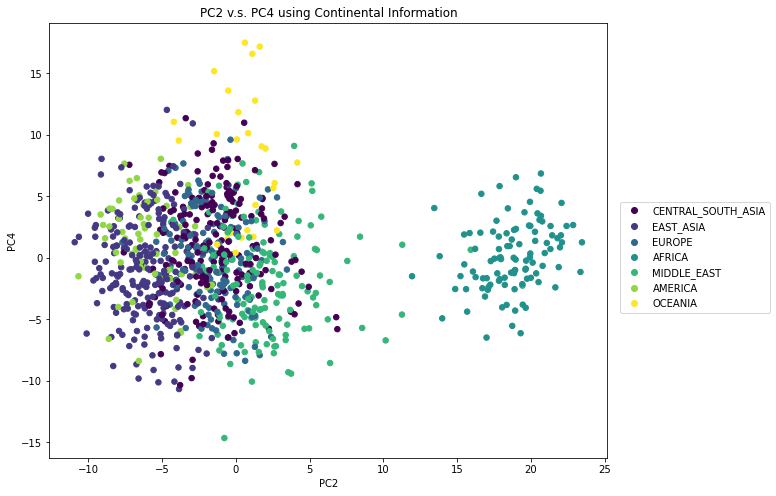

In [24]:
# Plot PC2 against PC4
plt.figure(figsize=(10,8))
plot = plt.scatter(data_plt['PC2'], data_plt['PC4'], s = 30, c=data_plt['continent'].map(colors))
plt.legend(handles=plot.legend_elements()[0], labels=list(continent), loc='upper right', bbox_to_anchor=(1.3, 0.6))
plt.xlabel("PC2")
plt.ylabel("PC4")
plt.title('PC2 v.s. PC4 using Continental Information')
plt.show()

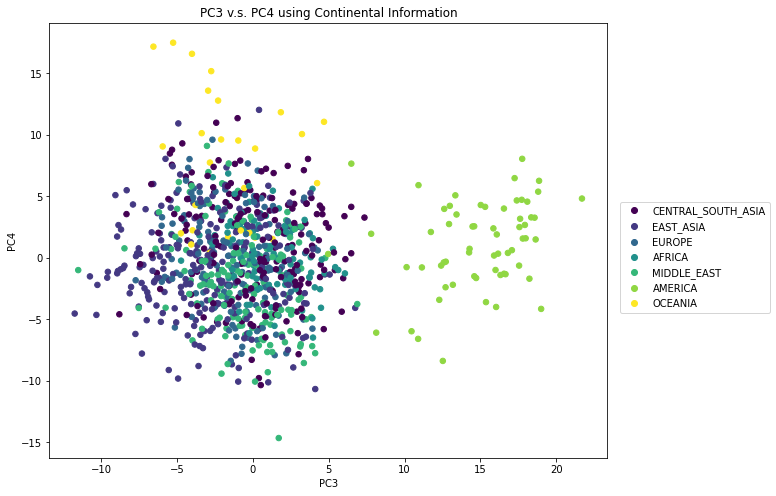

In [25]:
# Plot PC3 against PC4
plt.figure(figsize=(10,8))
plot = plt.scatter(data_plt['PC3'], data_plt['PC4'], s = 30, c=data_plt['continent'].map(colors))
plt.legend(handles=plot.legend_elements()[0], labels=list(continent), loc='upper right', bbox_to_anchor=(1.3, 0.6))
plt.xlabel("PC3")
plt.ylabel("PC4")
plt.title('PC3 v.s. PC4 using Continental Information')
plt.show()

# Problem 3

For PC plot with continental information, we can see different continental data has been efficiently distinguished on 4 PCs dimensions (i.e., they relatively dispersed in different dimensions). However, as the explained variance for a PC decreases, the clusters would be more difficult to split data on its dimension. Namely, the explained variance would be PC1 > PC2 > PC3 > PC4. We can observe clearly from the plot that when it comes to PC1 v.s. PC4 plot (or PC3 v.s. PC4 plot), the division between clusters becomes more obscured than PC1 v.s. PC2.

For PC plot with clustering method (i.e., K-Means Clustering), the data has been explicitly distinguished as 4 clusters. We pre-defined a list of possible cluster numbers, then evaluated the SSE of K-Means model. The final number of clusters is chosen by the elbow occurred in the SSE plot. The model divides the data into 4 clusters in the end, indicating genetic markers from whole population involved would generally distribute in 4 patterns.

Comparing results from Problem 1 and 2, we can see that K-Means Clustering misclassified *EAST_ASIA* and *OCENIA* as one type, and *CENTRAL_SOUTH_ASIA*, *EUROPE*, *MIDDLE_EAST* as one type. This is probably due to they have similar data patterns, and therefore the centroids of these different continental data are close to each other. Since K-Means Clustering is an unsupervised learning method (i.e., it doesn't consider the original data labels into training process), it would misclassified some analogous data into one cluster.

# Problem 4

## T-SNE

In [48]:
tsne = manifold.TSNE(n_components = 2, verbose = 1, init = 'random', learning_rate = 'auto', random_state = 80)
tsneDF = tsne.fit_transform(geno)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 927 samples in 0.003s...
[t-SNE] Computed neighbors for 927 samples in 0.097s...
[t-SNE] Computed conditional probabilities for sample 927 / 927
[t-SNE] Mean sigma: 8.018722
[t-SNE] KL divergence after 250 iterations with early exaggeration: 64.061188
[t-SNE] KL divergence after 1000 iterations: 1.584300


In [52]:
tsneDF = pd.DataFrame(tsneDF)
tsneDF.rename(columns = {0: 'X0', 1: 'X1'}, inplace = True)
tsneDF['label'] = newdf['continent']
tsneDF['cluster'] = data_plt['labels']
tsneDF

,X0,X1,label,cluster
0,1.571752,4.162666,CENTRAL_SOUTH_ASIA,1
1,-18.184248,0.177002,EAST_ASIA,3
2,-4.359309,-4.089320,CENTRAL_SOUTH_ASIA,1
3,12.759679,10.864527,EUROPE,1
4,-23.074623,-9.652617,EAST_ASIA,3
...,...,...,...,...
922,-0.485139,5.196733,CENTRAL_SOUTH_ASIA,1
923,-25.244413,13.806029,OCEANIA,3
924,-2.368433,5.073150,CENTRAL_SOUTH_ASIA,1
925,6.906443,2.398180,EUROPE,1


## Plot of T-SNE

### Clustering

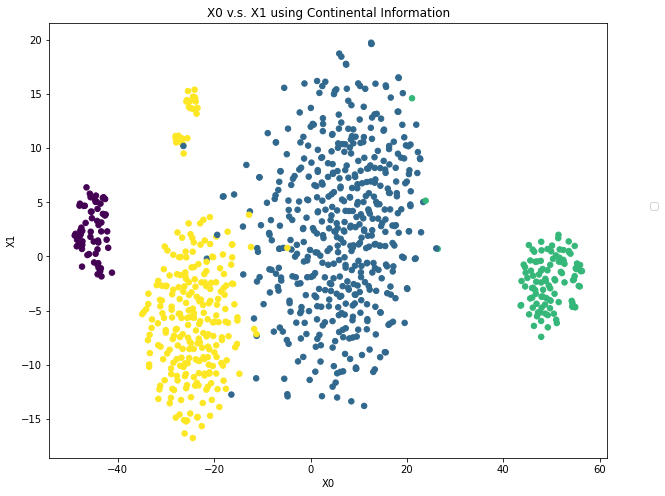

In [78]:
plt.figure(figsize = (10, 8))
plot = plt.scatter(tsneDF['X0'], tsneDF['X1'], s = 30, c=tsneDF['cluster'])
plt.legend(handles=plot.legend_elements()[1], labels=list(labels.unique()), loc='upper right', bbox_to_anchor=(1.1, 0.6))
plt.xlabel("X0")
plt.ylabel("X1")
plt.title('X0 v.s. X1 using Continental Information')
plt.show()

### Using continental information

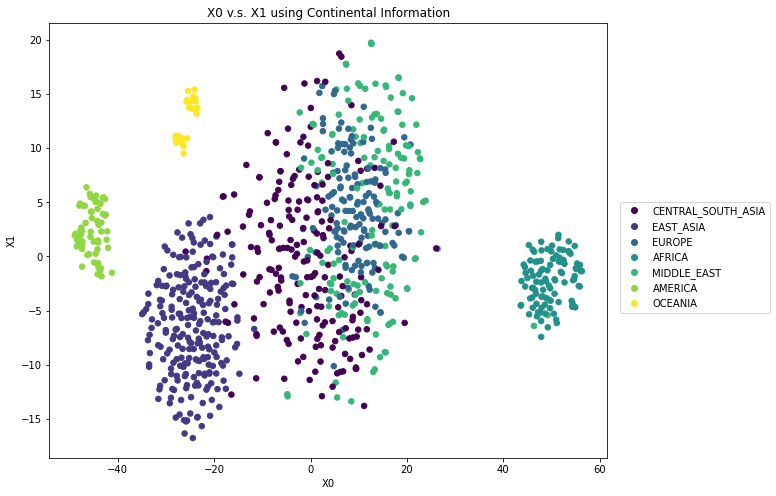

In [62]:
plt.figure(figsize = (10, 8))
plot = plt.scatter(tsneDF['X0'], tsneDF['X1'], s = 30, c=tsneDF['label'].map(colors))
plt.legend(handles=plot.legend_elements()[0], labels=list(continent), loc='upper right', bbox_to_anchor=(1.3, 0.6))
plt.xlabel("X0")
plt.ylabel("X1")
plt.title('X0 v.s. X1 using Continental Information')
plt.show()

## Comment

The T-SNE method reduced the feature size into 2 dimensions. From the plot we can see data are obviously sparsed using only 2 dimensions, which performs far much better than PCA. The data are clearly spread out and we can clearly see the distinction between different continental data. However, data from *CENTRAL_SOUTH_ASIA*, *EUROPE* and *MIDDLE_EAST* still gather together, and they can be hard to distinguish in this situation.

However, T-SNE is not as stable and consistent as PCA. We have to adjust our settings to fit a proper model, while improper one would lead to unsatisfying classification results. Therefore, it may be harder to interpret our model.